# Urbanization <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)


## Background
This notebook addressess the calculation of land consumption rate (urbanization) using **Normalized Differential Built Index (NDBI)** and  **Normalized Differential Vegetation Index (NDVI)**.


## Description
This notebook demonstrates how to:

1. Calculate urbanization index from NDBI and NDVI

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.  

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
from odc.ui import with_ui_cbk
import sys

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_plotting import display_map, rgb
from deafrica_bandindices import calculate_indices

## Load Landsat 8 data from the datacube

Here we are loading in a timeseries of `Landsat 8` satellite images through the datacube API.
This will provide us with some data to work with.

In [2]:
dc = datacube.Datacube(app='DEA_urbanization')

In [3]:
lat, lon = 5.7073, -0.3025
buffer = 0.1

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2016-01', '2017-12'),
    'resolution': (-30, 30),
    'align': (15, 15)
#     'measurements': ['*']
}

In [4]:
#Display area of interest
display_map(query['x'], query['y'], zoom_bias = 1)

In [5]:
# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

# Load available data from Landsat 8 and filter to retain only times
# with at least 99% good data
ds = load_ard(dc=dc, 
              products=['ls8_usgs_sr_scene'],
              output_crs=output_crs,
              progress_cbk= with_ui_cbk(),
              min_gooddata = 0.99, 
              **query)

# Print output data
print(ds)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Counting good quality pixels for each time step
Filtering to 4 out of 34 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 4 time steps
<xarray.Dataset>
Dimensions:          (time: 4, x: 744, y: 742)
Coordinates:
  * y                (y) float64 6.427e+05 6.426e+05 ... 6.205e+05 6.204e+05
  * time             (time) datetime64[ns] 2016-01-07T10:15:45.534960 ... 2017-12-27T10:15:52.569447
  * x                (x) float64 7.876e+05 7.877e+05 ... 8.099e+05 8.099e+05
Data variables:
    coastal_aerosol  (time, y, x) float32 282.0 320.0 322.0 ... 420.0 463.0
    blue             (time, y, x) float32 466.0 516.0 516.0 ... 703.0 779.0
    green            (time, y, x) float32 776.0 854.0 865.0 ... 1228.0 1318.0
    red              (time, y, x) float32 761.0 944.0 957.0 ... 1270.0 1388.0
    nir              (time, y, x) float32 2621.0 2578.0 2385.0 ... 2345.0

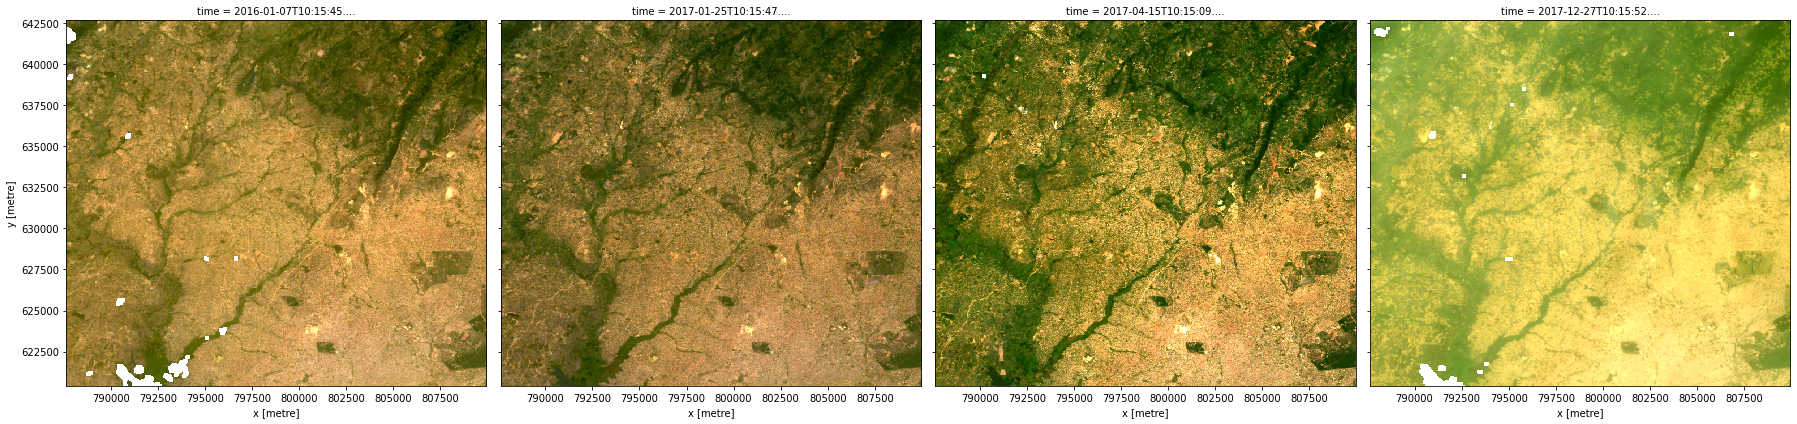

In [6]:
rgb(ds, index=list(range(0, 4)))

In [7]:
# Calculate NDVI and NDBI using the formula above
ds = calculate_indices(ds, index=['NDVI', 'NDBI', 'BAEI', 'BSI', 'BUI'], collection = 'c1', drop=True)

Dropping bands ['coastal_aerosol', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'sr_aerosol', 'radsat_qa']


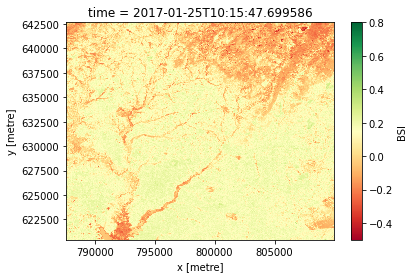

In [8]:
# Plot the results for one time step to see what they look like:
# ds_indices.NDVI.isel(time=0).plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')
ds.BSI.isel(time=1).plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')

In [9]:
ds['built_index'] = ds.NDBI - ds.NDVI
print(ds)

<xarray.Dataset>
Dimensions:      (time: 4, x: 744, y: 742)
Coordinates:
  * y            (y) float64 6.427e+05 6.426e+05 ... 6.205e+05 6.204e+05
  * time         (time) datetime64[ns] 2016-01-07T10:15:45.534960 ... 2017-12-27T10:15:52.569447
  * x            (x) float64 7.876e+05 7.877e+05 ... 8.099e+05 8.099e+05
Data variables:
    NDVI         (time, y, x) float32 0.5499705 0.46394092 ... 0.26071906
    NDBI         (time, y, x) float32 -0.15082331 -0.017765531 ... -0.055989277
    BAEI         (time, y, x) float32 1.3878229 1.1801317 ... 1.2778101
    BSI          (time, y, x) float32 -0.06779668 0.05179279 ... 0.053834606
    BUI          (time, y, x) float32 -0.7007938 -0.48170644 ... -0.31670833
    built_index  (time, y, x) float32 -0.7007938 -0.48170644 ... -0.31670833
Attributes:
    crs:      epsg:32630


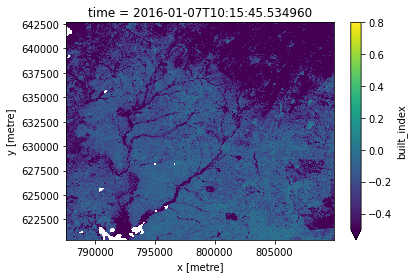

In [10]:
ds.built_index.isel(time=0).plot(vmin=-0.50, vmax=0.8, cmap='viridis')

In [11]:
#filter to get only the 
ds_urban_area = ds.where(ds.built_index > -0.1)

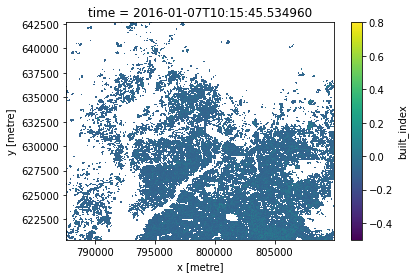

In [12]:
ds_urban_area.built_index.isel(time=[0]).plot(vmin=-0.50, vmax=0.8, cmap='viridis')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)